In [1]:
import numpy as np
import pandas as pd
import time
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import itertools
from z3 import *
from scipy.ndimage import measurements
from IPython.display import Markdown, display,Image,HTML
from math import gcd

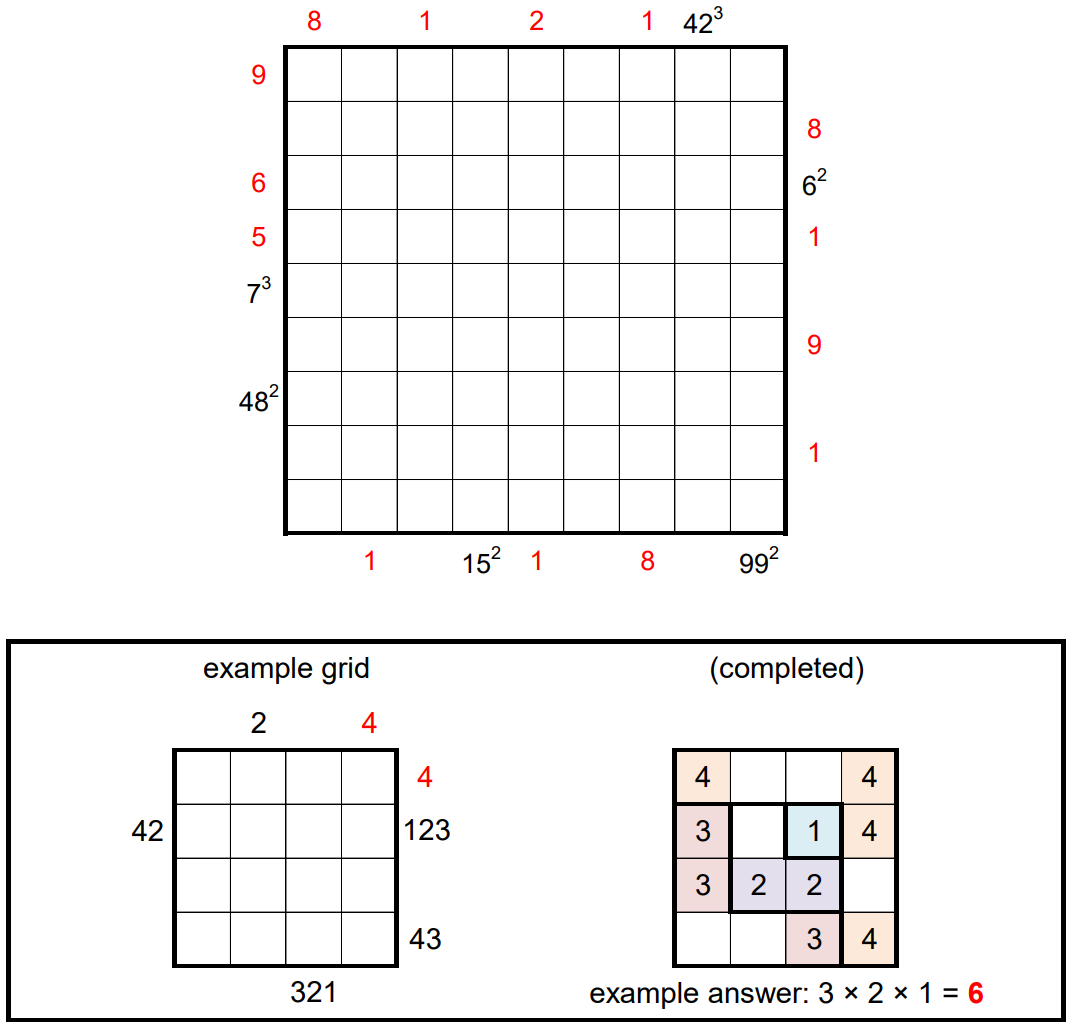

The grid presented here can be partitioned into 9 L-shaped “hooks”.
The largest is 9-by-9 (contains 17 squares), the next largest is
8-by-8 (contains 15 squares), and so on. The smallest hook is just a
single square. Find where the hooks are located, and place nine 9’s in
the largest hook, eight 8’s in the next-largest, etc., down to one 1
in the smallest hook. The filled squares must form a connected region. (Squares are
“connected” if they are orthogonally adjacent.) Furthermore, every
2-by-2 region must contain at least one unfilled square. A black number outside the grid indicates the product of the
concatenated numbers in that row or column, when viewed from that
position. (See the example, below.) A red number indicates the
greatest common factor of these concatenated numbers, again when
viewed from that position. The answer to this puzzle is the product of the areas of the connected
groups of empty squares in the completed grid.

In [2]:
url='https://www.janestreet.com/puzzles/hooks-6-index/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Image('https://www.janestreet.com/puzzles/Nov19_puzzle.png',width=400))
display(Markdown(" ".join(x[11:15])))

In [3]:
#Setup the constraints
top = [8,0,1,0,2,0,1,0,0]
rhs = [0,8,0,1,0,9,0,1,0]
bot = [0,1,0,0,1,0,8,0,0]
lhs = [9,0,6,5,0,0,0,0,0]
gcd1 = [top,bot,lhs,rhs]
    
top1 = [0,0,0,0,0,0,0,42**3,0]
rhs1 = [0,0,6**2,0,0,0,0,0,0]
bot1 = [0,0,0,15**2,0,0,0,0,99**2]
lhs1 = [0,0,0,0,7**3,0,48**2,0,0]
prod = [top1,bot1,lhs1,rhs1]

In [4]:
def sol_print(solved,matrix):
    fig,ax = plt.subplots(1,1,figsize=(4,4))
    x = np.array((solved*matrix).astype('int').astype('str'))
    x[x=="0"] =""
    ax =sns.heatmap(solved,annot=x,cbar=False,cmap="tab10",fmt="",linewidths=2,linecolor='k',annot_kws={"fontsize":12,"color":"k"},alpha=.6)
    ax.tick_params(left=False, bottom=False,labelleft=False, labelright=True)
    ax.axis("off")
    plt.tight_layout()
    plt.show()

In [5]:
def neigh(x,y,N):
    return [(i+x,j+y) for i,j in [(-1,0),(0,-1),(1,0),(0,1)] if i+x >=0 and i+x <N and j+y >=0 and j+y <N]

def areas(grid):
    labels, num = measurements.label(np.logical_not(grid!=0))
    areas = measurements.sum(np.logical_not(grid!=0), labels, index=range(1, num+1))
    print(areas)
    return np.prod(areas)

def numbers(split,line,hook_line):
    block = 0
    inblock =0
    for n,p in enumerate(split):         
        if p ==1:
            if inblock == 0:
                block += line[n]*hook_line[n]
                inblock = 1
            else:
                block *= 10
                block += line[n]*hook_line[n]         
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block
        
        
def numbers_check(line):
    block = 0
    inblock =0
    for n,p in enumerate(line):         
        if p > 0:
            if inblock == 0:
                block += p
                inblock = 1
            else:
                block *= 10
                block += p         
        else:
            if inblock == 1:
                yield block
                block = 0
                inblock = 0                    
    if inblock == 1:
        yield block
            
def const_gcd(line,hook_line,split,param):
    nums =[i for i in numbers(split,line,hook_line)]
    if len(nums) ==1:
        return  Implies(And([line[i] == int(e) for i,e in enumerate(split)]),nums[0] == param)
    else:
        return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),And([(c % param) == 0 for c in nums]))

def const_prod(line,hook_line,split,param):
    nums =[i for i in numbers(split,line,hook_line)]
    if len(nums) ==1:
        return  Implies(And([line[i] == int(e) for i,e in enumerate(split)]),nums[0] == param)
    else:
        return Implies(And([line[i] == int(e) for i,e in enumerate(split)]),Product(nums) == param)
    
def gcd_test(matrix,gcd1):
    for i,p in enumerate(gcd1[0]):
        if p >0:
            if gcd(*[i for i in numbers_check(matrix[:,i])]) != p:
                      return False
                  
    for i,p in enumerate(gcd1[1]):
        if p >0:
            if gcd(*[i for i in numbers_check(matrix[::-1,i])]) != p:
                      return False

    for i,p in enumerate(gcd1[2]):
        if p >0:
            if gcd(*[i for i in numbers_check(matrix[i,:])]) != p:
                  return False

    for i,p in enumerate(gcd1[3]):
        if p >0:
            if gcd(*[i for i in numbers_check(matrix[i,::-1])]) != p:
                      return False
    return True

In [6]:
test = np.array([[0, 9, 9, 9, 9, 0, 0, 9, 0],
                 [0, 0, 8, 0, 8, 8, 8, 8, 0],
                 [0, 0, 6, 0, 0, 0, 6, 0, 0],
                 [8, 7, 6, 5, 0, 5, 5, 5, 0],
                 [0, 7, 0, 0, 0, 0, 0, 4, 9],
                 [0, 7, 6, 5, 4, 3, 2, 0, 9],
                 [8, 0, 6, 0, 4, 0, 1, 2, 0],
                 [8, 7, 6, 0, 4, 3, 3, 0, 9],
                 [0, 0, 7, 0, 0, 0, 7, 7, 9]])

np.unique(test,return_counts=True)


(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 array([36,  1,  2,  3,  4,  5,  6,  7,  8,  9], dtype=int64))

setup done in 14.05 seconds


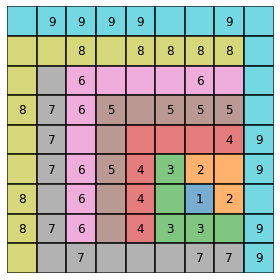

Took 4280.9176 seconds
[ 5.  2.  5. 10.  2.  1.  1.  5.  1.  1.  1.  2.]
solution is 10,000


In [15]:
start = time.time()
N =9
#set up the solver and variables.
s = Tactic("qffd").solver()

# H== hooks
H = np.array(IntVector("h",N**2),dtype=object).reshape((N,N))

row_fix =IntVector("r",N)
col_fix =IntVector("c",N)

s += [And(e>0,e<=N) for (i,j),e in np.ndenumerate(H)]
s += [And(e>=0,e<N) for e in row_fix+col_fix]

s += Distinct(row_fix)
s += Distinct(col_fix)

for n in range(1,N+1):
    s+=PbEq([(e==n,1) for _,e in np.ndenumerate(H)],2*n-1)
    if n!=1:
        s+=PbEq([(If(e==int(n),Sum([H[k,l] ==int(n) for k,l in neigh(i,j,N)]),0)==1,1) for (i,j),e in np.ndenumerate(H)],2)
        
for n in range(N):
    s += [Implies(e == int(n+1),Or(i == row_fix[n],j == col_fix[n])) for (i,j),e in np.ndenumerate(H)]
    

# Y = filled    
Y = np.array(IntVector("y",N**2),dtype=object).reshape((N,N))
s += [Or(e==0,e==1) for (i,j),e in np.ndenumerate(Y)]

for n in range(1,N+1):
    s+=PbEq([(And(e==n,Y[i,j]==1),1) for (i,j),e in np.ndenumerate(H)],n)

# no 2x2
s += [Or(Y[i,j] ==0,Y[i+1,j] ==0,Y[i,j+1] ==0,Y[i+1,j+1] ==0) for j in range(N-1) for i in range(N-1)]
    
edge ={}
Z = np.array(IntVector('z', N*N),dtype=object).reshape(N,N)

# create edges and variable to define order in connectivity tree
for i in range(N):
    for j in range(N):  
        for (k,l) in neigh(i,j,N):
            edge[(i,j,k,l)] = Int("e%d%d%d%d" % (i,j,k,l))
            s+=Or(edge[(i,j,k,l)] ==0,edge[(i,j,k,l)] ==1)

# no edges into or out of unfilled cells. Only one edge per cell     
for i in range(N):
    for j in range(N):       
        s += Implies(Y[i,j] ==0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) == 0)
        s += Implies(Y[i,j] ==0 , Sum([edge[(i,j,k,l)] for (k,l) in neigh(i,j,N)]) == 0)
        s += Implies(Y[i,j] > 0 , Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N)]) <= 1)
        for (k,l) in neigh(i,j,N):
            # Make edges one way to form a tree
            s += (edge[(i,j,k,l)] + edge[(k,l,i,j)]) <= 1

    # limit the order values
    s += [And(e>= 0 ,e <=int(N*N)) for (i,j),e in np.ndenumerate(Z)]

    # order is ascending along edges
    for i in range(N):
        for j in range(N):            
            s += [Implies(And(Y[i,j]!=0,edge[(k,l,i,j)]==1),Z[i,j] > Z[k,l]) for (k,l) in neigh(i,j,N)]

    # only one cell with no feed in => root
    s += PbEq([(And(Y[i,j] != 0,Sum([edge[(k,l,i,j)] for (k,l) in neigh(i,j,N) ]) == 0),1) for i in range(N) for j in range(N)],1)

    
for i,p in enumerate(gcd1[0]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=const_gcd(Y[:,i],H[:,i],shape,p)

for i,p in enumerate(gcd1[1]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=const_gcd(Y[::-1,i],H[::-1,i],shape,p)
                
for i,p in enumerate(gcd1[2]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=const_gcd(Y[i,:],H[i,:],shape,p)
                
for i,p in enumerate(gcd1[3]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=const_gcd(Y[i,::-1],H[i,::-1],shape,p)
                
for i,p in enumerate(prod[0]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=const_prod(Y[:,i],H[:,i],shape,p)

for i,p in enumerate(prod[1]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=const_prod(Y[::-1,i],H[::-1,i],shape,p)
                
for i,p in enumerate(prod[2]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=const_prod(Y[i,:],H[i,:],shape,p)
                
for i,p in enumerate(prod[3]):
    if p >0:
        for shape in itertools.product([0,1],repeat=N):
            if np.sum(shape)> 0 :
                s +=const_prod(Y[i,::-1],H[i,::-1],shape,p)
                      
print("setup done in {:.2f} seconds".format(time.time()-start))       


flag  = True
while flag:
    if s.check() == sat:
        m = s.model()
        evalu = np.vectorize(lambda x:m.evaluate(x).as_long())
        result_h =  evalu(H)
        result_y =  evalu(Y)
        if gcd_test(result_h*result_y,gcd1):
            sol_print(result_h,result_y)
            print("Took {:.4f} seconds".format(time.time()- start))
            soln = result_h*result_y
            print("solution is {:,.0f}".format(areas(soln)))
            flag = False
        else:
            print("gcd_fail")
            s+= Or([H[i,j] != int(e) for (i,j),e in np.ndenumerate(result_h)]+[Y[i,j] != int(e) for (i,j),e in np.ndenumerate(result_y)])
    else:
        print("unsat in {:.4f} seconds".format(time.time()- start))

   

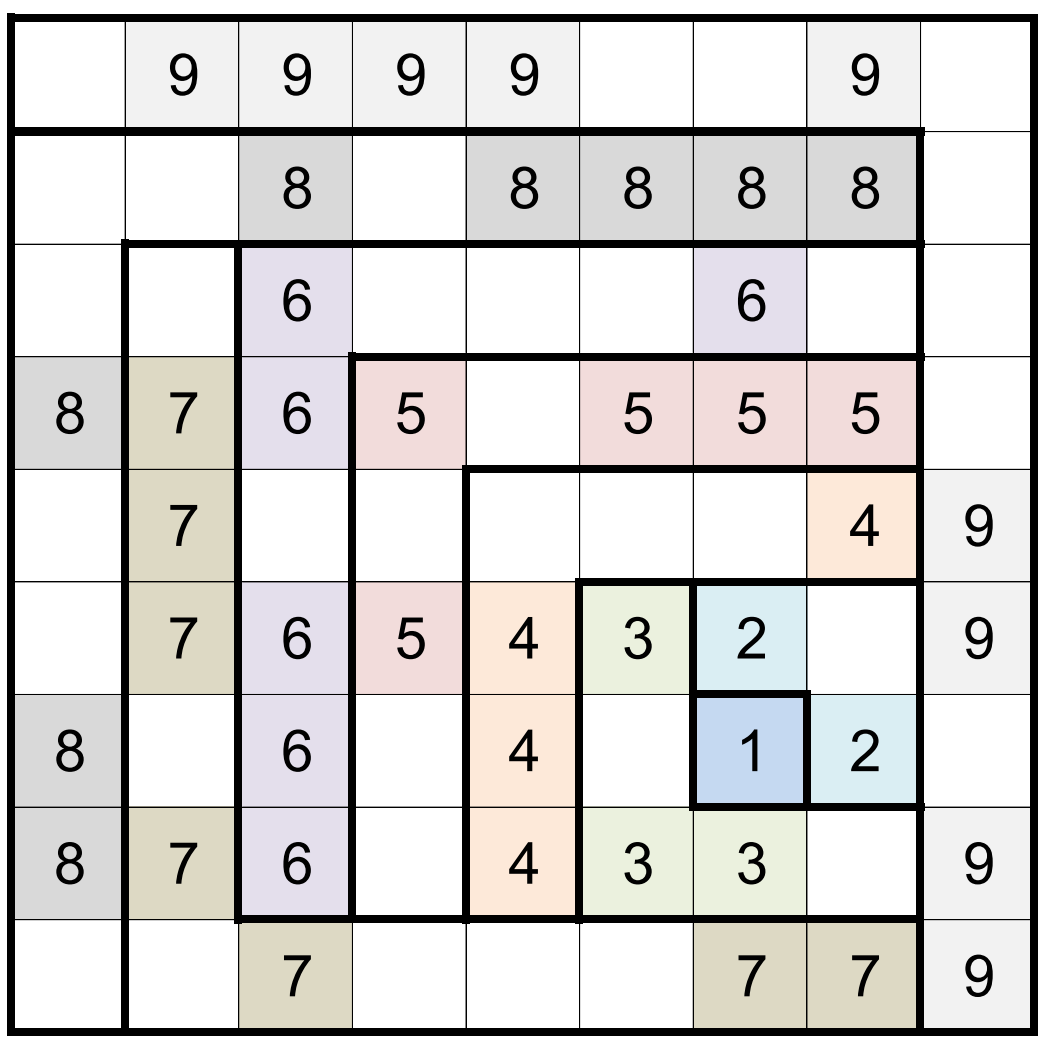

The answer to this month’s puzzle is 10,000 . Congrats to everyone
who solved it!

In [8]:
url='https://www.janestreet.com/puzzles/hooks-6-solution/'
res = requests.get(url)
soup = BeautifulSoup(res.content, 'html.parser')
x =[text for text in soup.body.stripped_strings]
#display([(i,j) for i,j in enumerate(x)])
display(Image('https://www.janestreet.com/puzzles/Nov19_solution.png',width=200))
display(Markdown(" ".join(x[11:14])))